### 予約をキャンセルするかしないかの分類問題です。

In [1]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode,iplot,plot
init_notebook_mode(connected=True)

予測するのは'is_canceled'で、1がキャンセル、0が予約です。

In [2]:
pd.set_option("display.max_columns",100)
df = pd.read_csv('hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
#データの型の確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119386 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           118902 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 n

In [4]:
for col in df.columns:
    null = df[col].isnull().sum()
    if null >= 1:
        print('{} : {}'.format(col, null))

children : 4
country : 488
agent : 16340
company : 112593


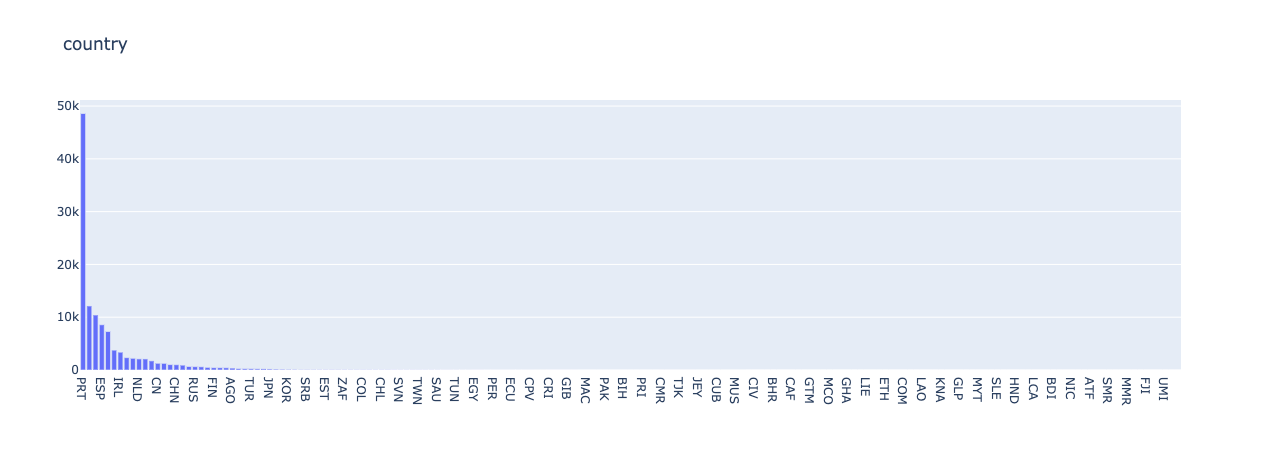

In [5]:
trace = go.Bar(x = df['country'].value_counts().index,
               y = df['country'].value_counts(),
               name = 'Country')
layout = go.Layout(title = 'country',
         legend = dict(orientation = 'h'))

data = [trace]
fig = go.Figure(data,layout)
iplot(fig)

In [6]:
#countryはPRTが圧倒的に多かった為、最頻値で補完
df['country'] = df['country'].fillna(df['country'].mode()[0])

In [7]:
#childrenは欠損値が少ない為0で補完
df['children'] = df['children'].fillna(0)

In [8]:
#agentの欠損値の割合を計算
print(df['agent'].value_counts().sum())
print(df['agent'].isnull().sum()/df['agent'].value_counts().sum())

103050
0.15856380397865114


In [9]:
#'agent','company'は欠損値が多く使えない為、削除
df.drop(columns=['agent', 'company'], axis=1, inplace=True)

In [10]:
#欠損値が無いかを確認
df.isnull().all()

hotel                             False
is_canceled                       False
lead_time                         False
arrival_date_year                 False
arrival_date_month                False
arrival_date_week_number          False
arrival_date_day_of_month         False
stays_in_weekend_nights           False
stays_in_week_nights              False
adults                            False
children                          False
babies                            False
meal                              False
country                           False
market_segment                    False
distribution_channel              False
is_repeated_guest                 False
previous_cancellations            False
previous_bookings_not_canceled    False
reserved_room_type                False
assigned_room_type                False
booking_changes                   False
deposit_type                      False
days_in_waiting_list              False
customer_type                     False


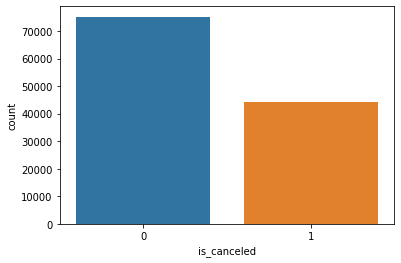

In [11]:
#キャンセルと予約の可視化
#1がキャンセル、0が予約です。
sns.countplot(df['is_canceled'])

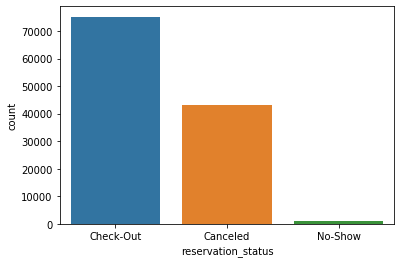

In [12]:
#チェックアウト済かキャンセルか連絡なくキャンセルかを可視化
sns.countplot(df['reservation_status'])

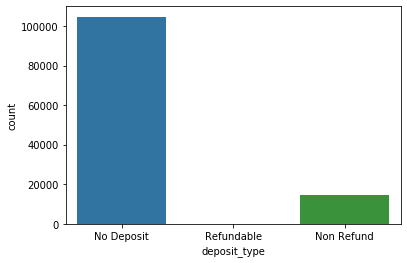

In [13]:
#事前に宿泊代を払うかどうか。Non Refundは返金できない。No Depositは前払い不要。Rrefundable deposit_typeは返金可能で前払い
sns.countplot(df['deposit_type'])

In [14]:
df.select_dtypes(exclude='object')

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,0,342,2015,27,1,0,0,2,0.0,0,0,0,0,3,0,0.00,0,0
1,0,737,2015,27,1,0,0,2,0.0,0,0,0,0,4,0,0.00,0,0
2,0,7,2015,27,1,0,1,1,0.0,0,0,0,0,0,0,75.00,0,0
3,0,13,2015,27,1,0,1,1,0.0,0,0,0,0,0,0,75.00,0,0
4,0,14,2015,27,1,0,2,2,0.0,0,0,0,0,0,0,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,2017,35,30,2,5,2,0.0,0,0,0,0,0,0,96.14,0,0
119386,0,102,2017,35,31,2,5,3,0.0,0,0,0,0,0,0,225.43,0,2
119387,0,34,2017,35,31,2,5,2,0.0,0,0,0,0,0,0,157.71,0,4
119388,0,109,2017,35,31,2,5,2,0.0,0,0,0,0,0,0,104.40,0,0


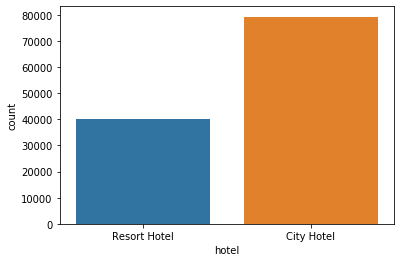

In [15]:
#ホテルタイプの可視化
sns.countplot(df['hotel'])

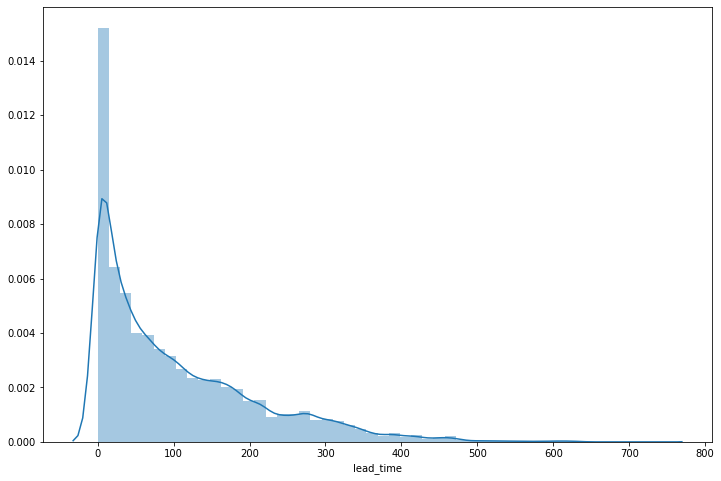

In [16]:
#lead_time(チェックインの何日前から予約したかのグラフ)
plt.figure(figsize=(12,8))
sns.distplot(df['lead_time'])

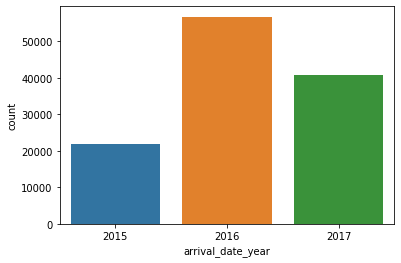

In [17]:
#年ごとでの予約（キャンセルも含む）
sns.countplot(df['arrival_date_year'])

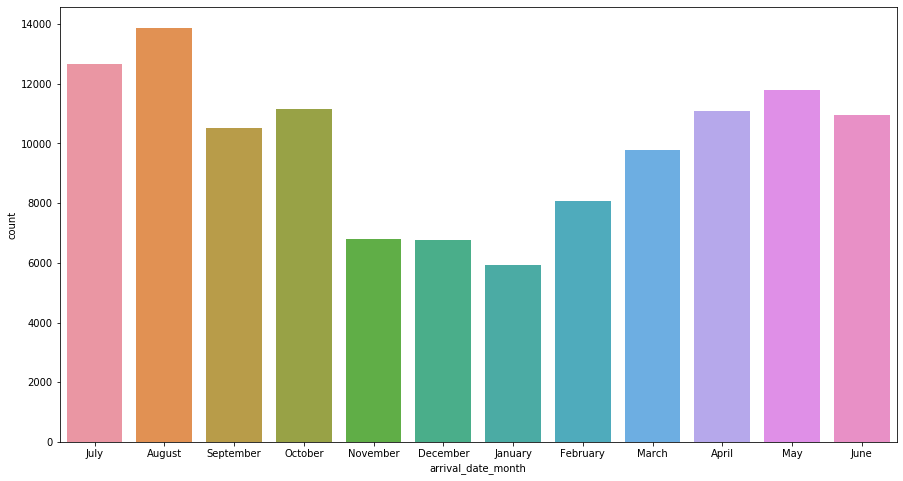

In [18]:
#月ごとでの予約（キャンセルも含む）
plt.figure(figsize=(15,8))
sns.countplot(df['arrival_date_month'])

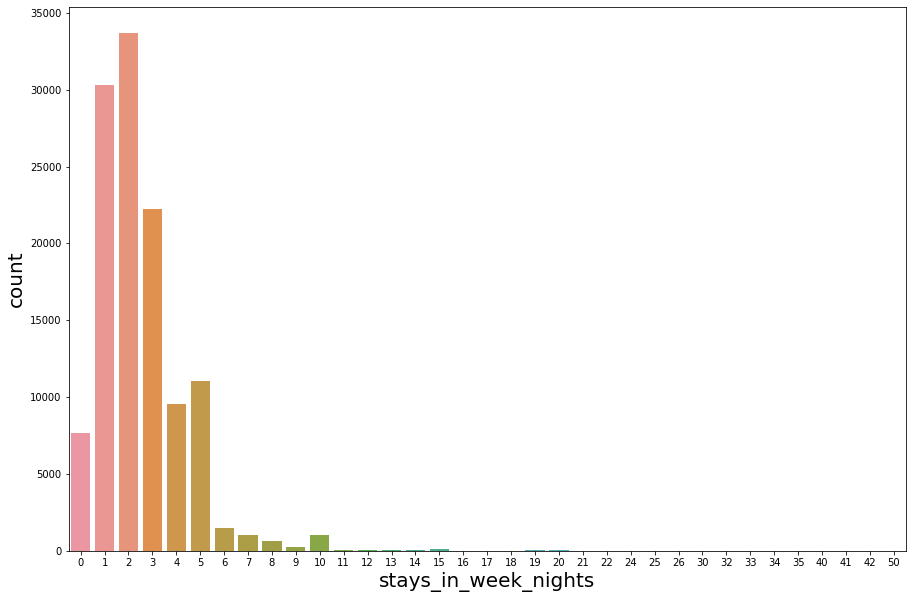

In [19]:
#stays_in_week_nights(泊まる日が平日だった日数)
plt.figure(figsize=(15, 10))
plt.xlabel('stays_in_week_nights', fontsize=20)
plt.ylabel('count', fontsize=20)
sns.countplot(df['stays_in_week_nights'])

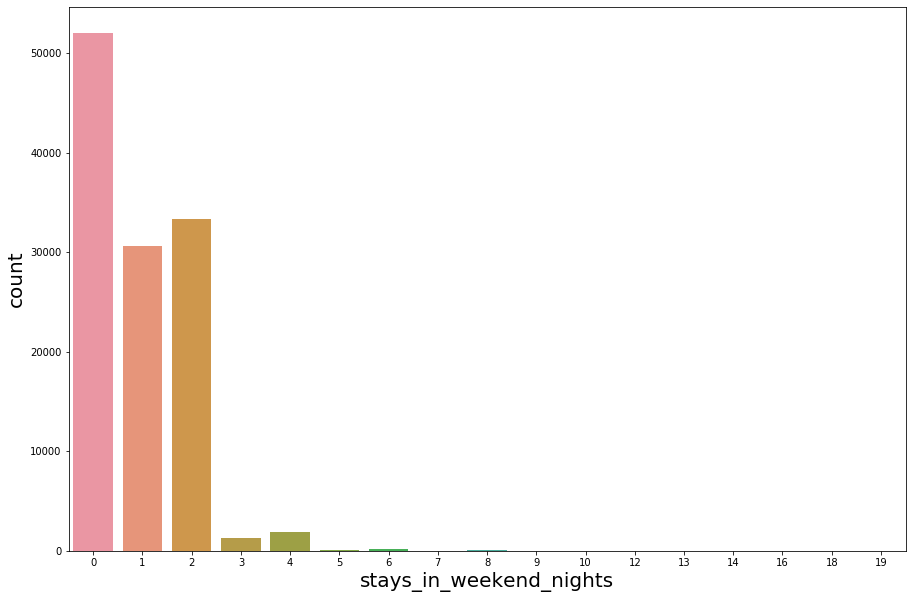

In [20]:
#stays_in_weekend_nights(泊まる日が週末だった日数)
plt.figure(figsize=(15,10))
plt.xlabel('stays_in_weekend_nights', fontsize=20)
plt.ylabel('count', fontsize=20)
sns.countplot(df['stays_in_weekend_nights'])

In [21]:
#キャンセルと予約だったもののadr(料金)の平均　　　　０が予約、1がキャンセル
df[['is_canceled','adr']].groupby('is_canceled').mean()

,adr
is_canceled,
0,99.987693
1,104.964333


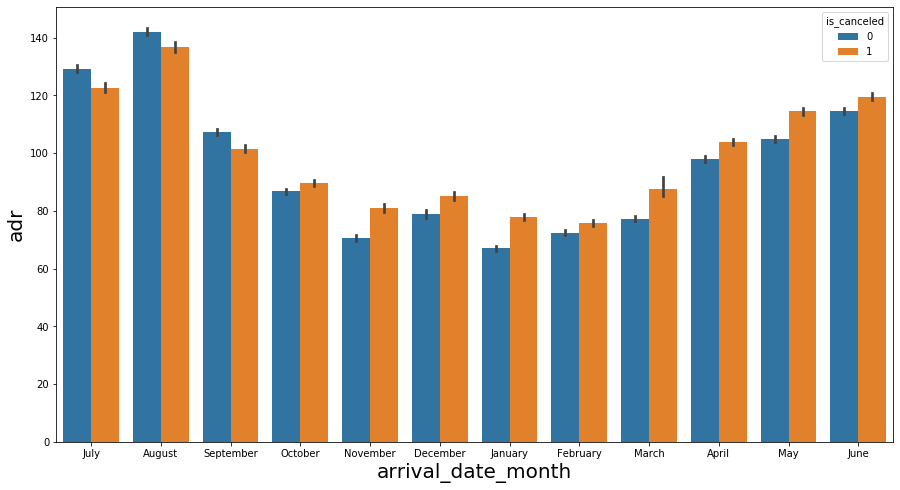

In [22]:
#利用月の可視化
plt.figure(figsize=(15,8))
plt.xlabel('arrival_date_month', fontsize=20)
plt.ylabel('adr', fontsize=20)
sns.barplot(x=df['arrival_date_month'], y=df['adr'],hue='is_canceled',data=df)

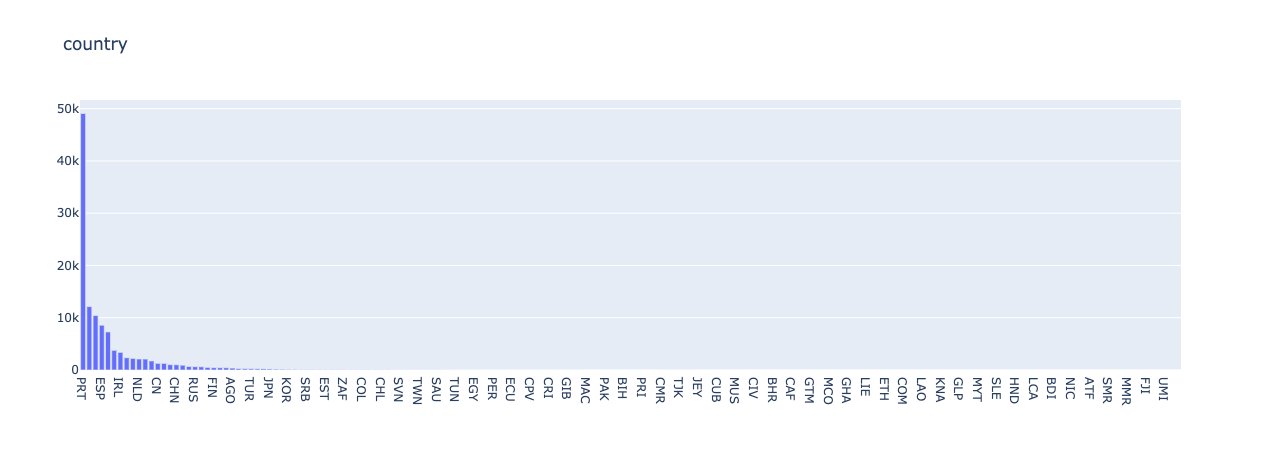

In [23]:
#宿泊客がどこの国だったかの可視化
trace=go.Bar(
                        x=df['country'].value_counts().index,
                        y=df['country'].value_counts(),
                        name='Country')
layout=go.Layout(title='country',
                                legend=dict(orientation='h'))

data=[trace]
fig=go.Figure(data,layout)
iplot(fig)

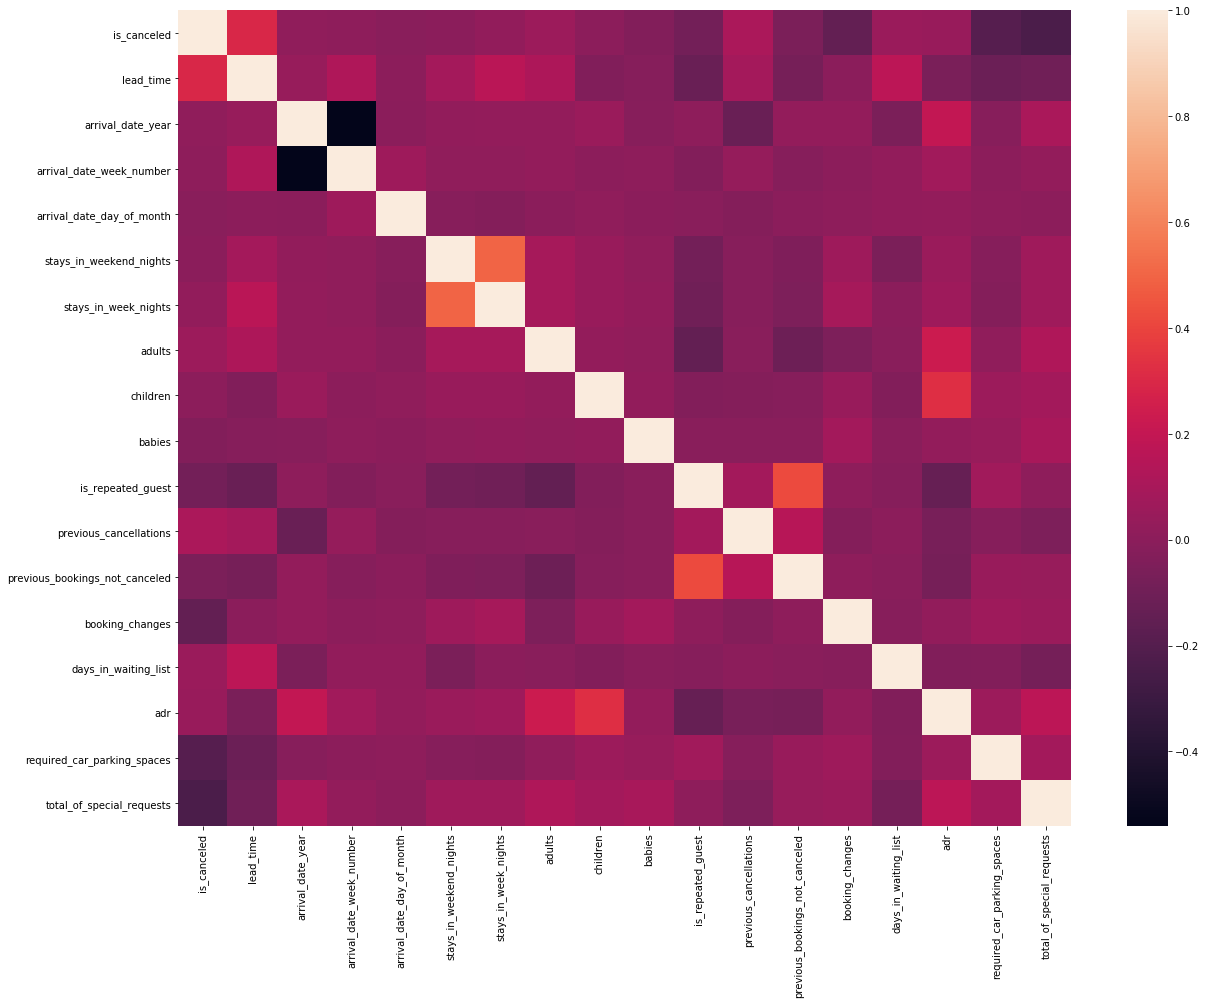

In [24]:
#相関を確認
plt.figure(figsize=(20,15))
sns.heatmap(df.corr())

In [25]:
#arrival_date_yearとarrival_date_week_numberで負の相関がある為、arrival_date_week_numberを削除
df = df.drop(columns='arrival_date_week_number' ,axis=1)

In [26]:
#数値型でカテゴリ変数のものを確認
print(df['total_of_special_requests'].unique())
print(df['required_car_parking_spaces'].unique())
print(df['previous_bookings_not_canceled'].unique())

[0 1 3 2 4 5]
[0 1 2 8 3]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 25 27 28 29 30 19 26 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72]


In [27]:
#データ型がobjectでいいかどうかを確認
df.select_dtypes(exclude='object')

,is_canceled,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,0,342,2015,1,0,0,2,0.0,0,0,0,0,3,0,0.00,0,0
1,0,737,2015,1,0,0,2,0.0,0,0,0,0,4,0,0.00,0,0
2,0,7,2015,1,0,1,1,0.0,0,0,0,0,0,0,75.00,0,0
3,0,13,2015,1,0,1,1,0.0,0,0,0,0,0,0,75.00,0,0
4,0,14,2015,1,0,2,2,0.0,0,0,0,0,0,0,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,2017,30,2,5,2,0.0,0,0,0,0,0,0,96.14,0,0
119386,0,102,2017,31,2,5,3,0.0,0,0,0,0,0,0,225.43,0,2
119387,0,34,2017,31,2,5,2,0.0,0,0,0,0,0,0,157.71,0,4
119388,0,109,2017,31,2,5,2,0.0,0,0,0,0,0,0,104.40,0,0


In [28]:
df['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [29]:
df['arrival_date_month']=df['arrival_date_month'].map({'July':'07','August':'08','September':'09','October':'10','November':'11','December':'12',
                                                      'January':'01','February':'02','March':'03','April':'04','May':'05','June':'06'})

### 外れ値の確認

In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119390.0,0.103886,0.398555,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0
is_repeated_guest,119390.0,0.031912,0.175767,0.00,0.00,0.000,0.0,1.0


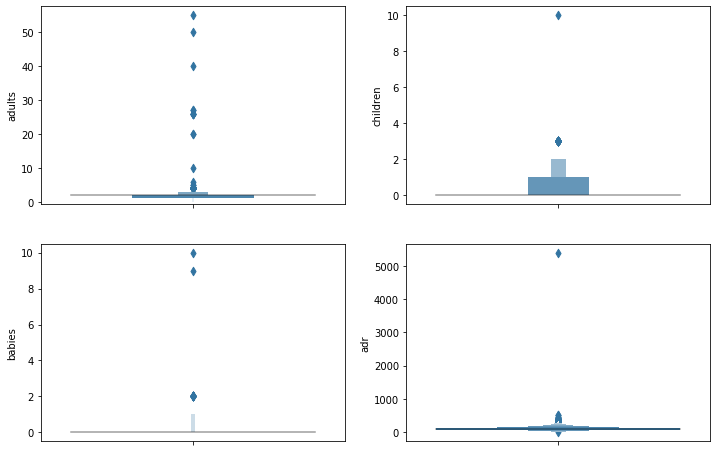

In [31]:
#'adults', 'children', 'babies', 'adr'外れ値の可能性があるので確認
num_feature = df[['adults', 'children', 'babies', 'adr']]
fig = plt.figure(figsize=(12, 8))

for i in range(len(num_feature.columns)):
    fig.add_subplot(2, 2, i + 1)
    sns.boxenplot(y = num_feature.iloc[:, i])

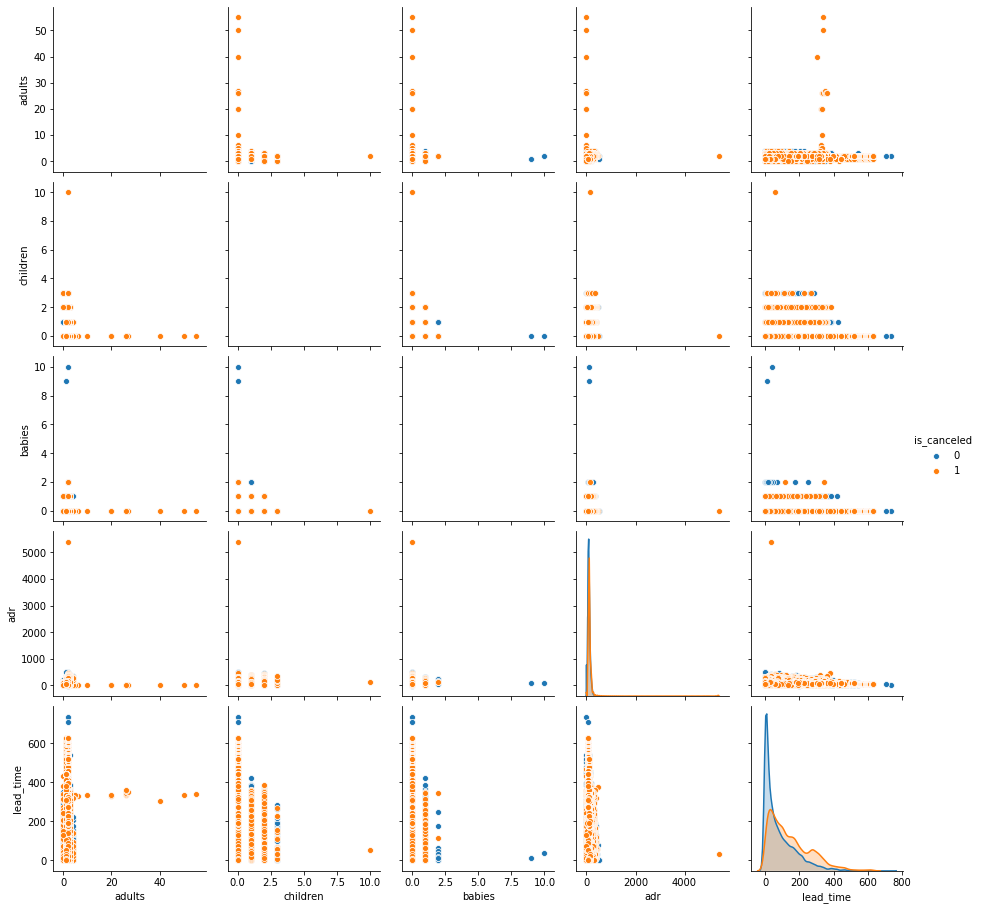

In [32]:
sns.pairplot(df, hue='is_canceled', vars=['adults', 'children', 'babies', 'adr', 'lead_time'])

In [33]:
df = df[df['adults'] < 5]
df = df[df['children'] <= 5]
df = df[df['babies'] <= 5]
df = df[(df['adr'] <= 4000) & (df['adr'] >= 0)]

In [34]:
#adults(大人の人数)に外れ値がないか確認。
df['adults'].unique()

array([2, 1, 3, 4, 0])

In [35]:
df['adults'].value_counts().sort_values(ascending=True)

4       62
0      403
3     6202
1    23026
2    89676
Name: adults, dtype: int64

In [36]:
#大人0人などがあったので最頻値で補完
df['adults'] = df['adults'].replace(0, df['adults'].mode()[0])
df['adults'].value_counts().sort_values(ascending=True)

4       62
3     6202
1    23026
2    90079
Name: adults, dtype: int64

In [37]:
#新たにfamily（大人+子供+赤ちゃん）の特徴量を追加
df['total_number_of_people'] = df['adults'] + df['children'] + df['babies']
df = df.drop(['adults', 'children', 'babies'], axis=1)

In [38]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_number_of_people
0,Resort Hotel,0,342,2015,07,1,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2.0
1,Resort Hotel,0,737,2015,07,1,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2.0
2,Resort Hotel,0,7,2015,07,1,0,1,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,1.0
3,Resort Hotel,0,13,2015,07,1,0,1,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,1.0
4,Resort Hotel,0,14,2015,07,1,0,2,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,2.0


#### カテゴリ変数をラベルエンコーディング

In [39]:
from sklearn.preprocessing import LabelEncoder

label_col=['hotel','meal','country','market_segment','distribution_channel','reserved_room_type',
                  'deposit_type','customer_type']

for col in label_col:
    lbl=LabelEncoder()
    df[col]=lbl.fit_transform(df[col].values)
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_number_of_people
0,1,0,342,2015,07,1,0,0,0,135,3,1,0,0,0,2,C,3,0,0,2,0.0,0,0,Check-Out,2015-07-01,2.0
1,1,0,737,2015,07,1,0,0,0,135,3,1,0,0,0,2,C,4,0,0,2,0.0,0,0,Check-Out,2015-07-01,2.0
2,1,0,7,2015,07,1,0,1,0,59,3,1,0,0,0,0,C,0,0,0,2,75.0,0,0,Check-Out,2015-07-02,1.0
3,1,0,13,2015,07,1,0,1,0,59,2,0,0,0,0,0,A,0,0,0,2,75.0,0,0,Check-Out,2015-07-02,1.0
4,1,0,14,2015,07,1,0,2,0,59,6,3,0,0,0,0,A,0,0,0,2,98.0,0,1,Check-Out,2015-07-03,2.0


In [40]:
#is_canceledと相関があるものなどを削除
df=df.drop(columns=['reservation_status','reservation_status_date','assigned_room_type',
                   'previous_cancellations','previous_bookings_not_canceled',
                   'days_in_waiting_list','stays_in_week_nights','booking_changes','distribution_channel'],axis=1)

- reservation_status(予約の状態がキャンセルか予約が分かり、説明変数に入れると正しく分類されない可能性がある)

その他、booking_changes(予約を変更した回数)などに関しても予約したかどうかがわかってしまう可能性がある特徴量を削除

In [41]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,meal,country,market_segment,is_repeated_guest,reserved_room_type,deposit_type,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_number_of_people
0,1,0,342,2015,07,1,0,0,135,3,0,2,0,2,0.0,0,0,2.0
1,1,0,737,2015,07,1,0,0,135,3,0,2,0,2,0.0,0,0,2.0
2,1,0,7,2015,07,1,0,0,59,3,0,0,0,2,75.0,0,0,1.0
3,1,0,13,2015,07,1,0,0,59,2,0,0,0,2,75.0,0,0,1.0
4,1,0,14,2015,07,1,0,0,59,6,0,0,0,2,98.0,0,1,2.0


#### ダミー変数化

In [42]:
df=pd.get_dummies(df,drop_first=True)

In [43]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,meal,country,market_segment,is_repeated_guest,reserved_room_type,deposit_type,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_number_of_people,arrival_date_month_02,arrival_date_month_03,arrival_date_month_04,arrival_date_month_05,arrival_date_month_06,arrival_date_month_07,arrival_date_month_08,arrival_date_month_09,arrival_date_month_10,arrival_date_month_11,arrival_date_month_12
0,1,0,342,2015,1,0,0,135,3,0,2,0,2,0.0,0,0,2.0,0,0,0,0,0,1,0,0,0,0,0
1,1,0,737,2015,1,0,0,135,3,0,2,0,2,0.0,0,0,2.0,0,0,0,0,0,1,0,0,0,0,0
2,1,0,7,2015,1,0,0,59,3,0,0,0,2,75.0,0,0,1.0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,13,2015,1,0,0,59,2,0,0,0,2,75.0,0,0,1.0,0,0,0,0,0,1,0,0,0,0,0
4,1,0,14,2015,1,0,0,59,6,0,0,0,2,98.0,0,1,2.0,0,0,0,0,0,1,0,0,0,0,0


In [44]:
#数値型の特徴量をスケーリング
from sklearn.preprocessing import StandardScaler

num_col=['stays_in_weekend_nights', 'adr', 'lead_time', 'total_number_of_people']
for col in num_col:
    scaler=StandardScaler()
    df[col]=scaler.fit_transform(np.array(df[col].values).reshape(-1,1))
    
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,meal,country,market_segment,is_repeated_guest,reserved_room_type,deposit_type,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_number_of_people,arrival_date_month_02,arrival_date_month_03,arrival_date_month_04,arrival_date_month_05,arrival_date_month_06,arrival_date_month_07,arrival_date_month_08,arrival_date_month_09,arrival_date_month_10,arrival_date_month_11,arrival_date_month_12
0,1,0,2.227872,2015,1,-0.928804,0,135,3,0,2,0,2,-2.114611,0,0,0.043348,0,0,0,0,0,1,0,0,0,0,0
1,1,0,5.925106,2015,1,-0.928804,0,135,3,0,2,0,2,-2.114611,0,0,0.043348,0,0,0,0,0,1,0,0,0,0,0
2,1,0,-0.907757,2015,1,-0.928804,0,59,3,0,0,0,2,-0.556714,0,0,-1.488897,0,0,0,0,0,1,0,0,0,0,0
3,1,0,-0.851596,2015,1,-0.928804,0,59,2,0,0,0,2,-0.556714,0,0,-1.488897,0,0,0,0,0,1,0,0,0,0,0
4,1,0,-0.842236,2015,1,-0.928804,0,59,6,0,0,0,2,-0.078959,0,1,0.043348,0,0,0,0,0,1,0,0,0,0,0


In [45]:
df.shape

(119369, 28)

In [46]:
#説明変数をXに、目的変数をyに代入
X=df.drop(columns=['is_canceled'],axis=1)
y=df['is_canceled']
print(X.shape)
print(y.shape)

(119369, 27)
(119369,)


### 交差検証でモデル選択

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score,KFold

In [48]:
KFold = KFold(n_splits=5,shuffle=True,random_state=0)
Random_cross = RandomForestClassifier()
svc_cross = LinearSVC()

In [49]:
random_score = cross_val_score(Random_cross,X,y,cv=KFold)
svc_score = cross_val_score(svc_cross,X,y,cv=KFold)

In [50]:
print('RandomForest:{}'.format(random_score.mean()))
print('SVC:{}'.format(svc_score.mean()))

RandomForest:0.8695809154247403
SVC:0.6447547052175137


In [51]:
#訓練データとテストデータに分割
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [52]:
#モデルの作成
random_forest = RandomForestClassifier()
random_forest.fit(X_train,y_train)
pred_y=random_forest.predict(X_test)
print(random_forest.score(X_train,y_train))
print(random_forest.score(X_test,y_test))

0.9866072425887452
0.8688804744831283


### 過学習だった為グリッドサーチ

In [53]:
from sklearn.model_selection import GridSearchCV

In [54]:
params_random = {'max_depth':[i for i in range(3,25)],
                               'criterion':['gini','entropy']
                               }

clf_grid = GridSearchCV(RandomForestClassifier(),params_random,scoring='accuracy')
clf_grid.fit(X_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [55]:
clf_grid.score(X_train,y_train)

0.9360409266581775

In [56]:
clf_grid.score(X_test,y_test)

0.8688134570921154

In [57]:
clf_grid.best_score_

0.8633469606594733

#### Lightgbmで特徴量の重要度を可視化

In [58]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()
lgb.fit(X_train,y_train)
print(lgb.score(X_train,y_train))
print(lgb.score(X_test,y_test))

0.8577284811116324
0.8553429614985089


In [59]:
importance = pd.DataFrame({'importance':lgb.feature_importances_},index=X_train.columns)
importance = importance.sort_values(by='importance',ascending=False)
importance

,importance
lead_time,463
country,431
adr,411
arrival_date_year,246
customer_type,210
market_segment,195
arrival_date_day_of_month,123
total_of_special_requests,119
meal,92
required_car_parking_spaces,89


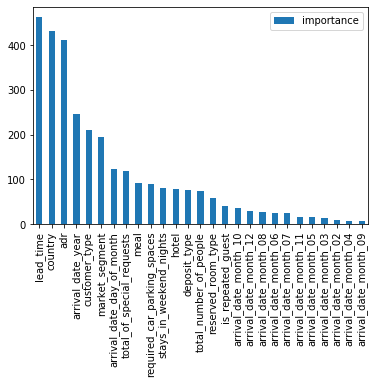

In [60]:
importance.plot.bar()